In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from uncertainty_forest.uncertainty_forest import UncertaintyForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from scipy.stats import entropy, norm
from scipy.integrate import quad

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import tree

# Taken from Richard's "Reprod Figure 2"

In [3]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import math

def cef_estimate(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1, max_features = 1.):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf, max_features = math.ceil(int(math.sqrt(X.shape[1])))), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        
        # RONAK EDIT STARTS HERE ################ In newer sklearn, generate unsampled takes a positional argument.
        #unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X), int((1 - max_samples)*len(X)))
        # RONAK EDIT ENDS HERE ##################
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].reshape(1, -1)).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

np.warnings.filterwarnings('ignore')

/home/ronak/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
def CART_estimate(X, y, n_trees = 300, bootstrap = True, depth = 30):
    model = RandomForestClassifier(bootstrap = bootstrap, n_estimators =n_trees, max_depth = depth, max_features = math.ceil(int(math.sqrt(X.shape[1]))))
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree_in_forest in model:
        # get number of training elements in each partition
        node_counts = tree_in_forest.tree_.n_node_samples
        # get counts for all x (x.length array)
        partition_counts = np.asarray([node_counts[x] for x in tree_in_forest.apply(X)])
        # get class probability for all x (x.length, n_classes)
        class_probs = tree_in_forest.predict_proba(X)
        # get elements by performing row wise multiplication
        elems = np.multiply(class_probs, partition_counts[:, np.newaxis])
        # update counts for that tree
        class_counts += elems
    probs = class_counts/class_counts.sum(axis=1, keepdims=True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

## Simulate Data and Conditional Entropy Prediction

In [5]:
def generate_data(n, d, mu = 1):
    n_1 = np.random.binomial(n, .5) # number of class 1
    mean = np.zeros(d)
    mean[0] = mu
    X_1 = np.random.multivariate_normal(mean, np.eye(d), n_1)
    
    X = np.concatenate((X_1, np.random.multivariate_normal(-mean, np.eye(d), n - n_1)))
    y = np.concatenate((np.repeat(1, n_1), np.repeat(0, n - n_1)))
  
    return X, y

def split_train_eval(X, y, frac_eval):
    
    if frac_eval == 0:
        return X, y, [], []
    
    n = len(y)
    n_eval = int(np.floor(frac_eval*n))
    eval_indices = np.random.choice(np.arange(n), size = n_eval, replace = False)
    X_eval = X[eval_indices, :]
    y_eval = y[eval_indices]
    X = np.delete(X, eval_indices, axis = 0)
    y = np.delete(y, eval_indices, axis = 0)
    
    return X, y, X_eval, y_eval

In [6]:
# def conditional_entropy_distribution(n, d, frac_eval, algos, num_trials, mu, parallel = False):
#     # For each trial, generate data and compute conditional entropy for each algorithm.
#     def worker(t):
#         # X, y, X_eval = generate_data(n, d, frac_eval, mu = mu)
#         X, y = generate_data(n, d, 0, mu = mu)
#         ret = np.zeros(len(algos))
#         for i in range(len(algos)):
#             obj = algos[i]['instance']
#             if algos[i]['label'] == 'UF':
#                 n_estimators = obj['n_estimators']
#                 ret[i] = cef_estimate(X, y, n_estimators = n_estimators, min_samples_leaf = int(np.log(len(X))))
#             else:
#                 X, y, X_eval, y_eval = split_train_eval(X, y, frac_eval)
#                 obj.fit(X, y)
#                 p = obj.predict_proba(X_eval)
#                 ret[i] = np.mean(entropy(p.T, base = np.exp(1)))
#         return ret
    
#     if parallel:
#         predicted_cond_entropy = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
#     else:
#         predicted_cond_entropy = np.zeros((num_trials, len(algos)))
#         for t in tqdm(range(num_trials)):
#             predicted_cond_entropy[t, :] = worker(t)
            
#     return predicted_cond_entropy

## Compute True Conditional Entropy

In [7]:
def true_cond_entropy(mu, base = np.exp(1)):
    def func(x):
        p = 0.5 * norm.pdf(x, mu, 1) + 0.5 * norm.pdf(x, -mu, 1)
        return -p * np.log(p) / np.log(base)
    
    H_X = quad(func, -20, 20)
    H_XY = 0.5*(1.0 + np.log(2 * np.pi)) / np.log(base)
    H_Y = np.log(2.0) / np.log(base)
    # I_XY = H_X - H_XY = H_Y - H_YX
    return H_Y - H_X[0] + H_XY

## Conditional Entropy versus Sample Size

In [8]:
# def conditional_entropy_by_n(sample_sizes, d, frac_eval, algos, num_trials, mu, parallel = False):
#     # Repeat for all 'n', and save output in the 'algos' array.
#     cond_entropy_range = np.zeros((len(sample_sizes), num_trials, len(algos)))
#     for i in range(len(sample_sizes)):
#         cond_entropy_range[i, :, :] = conditional_entropy_distribution(sample_sizes[i], 
#                                                                        d, 
#                                                                        frac_eval, 
#                                                                        algos, 
#                                                                        num_trials, 
#                                                                        mu = mu,
#                                                                        parallel = parallel)
        
#     for j in range(len(algos)):
#         algos[j]['cond_entropy_by_n_d_%d' % d] = cond_entropy_range[:, :, j]
        
#     with open('algos_fig2.pkl', 'wb') as f:
#         pickle.dump(algos, f)
#     with open('sample_sizes_d_%d.pkl' % d, 'wb') as f:
#         pickle.dump(sample_sizes, f)
        
#     return algos

In [9]:
def plot_cond_entropy_by_n(ax, num_plotted_trials, d, mu):
        
    sample_sizes = pickle.load(open('sample_sizes_d_%d.pkl' % d, 'rb'))
    uf = pickle.load(open('uf_by_n_d_%d.pkl' % d, 'rb'))
    cart = pickle.load(open('cart_by_n_d_%d.pkl' % d, 'rb'))
    irf = pickle.load(open('irf_by_n_d_%d.pkl' % d, 'rb'))
    results = [cart, irf, uf]
    
    for j, algo in enumerate(algos):
        # Plot the mean over trials as a solid line.
        ax.plot(sample_sizes,
                np.mean(results[j], axis = 1).flatten(), 
                label = algo['label'], 
                linewidth = 4, 
                color = algo['color'])
        # Use transparent lines to show other trials.
        for t in range(num_plotted_trials):
            ax.plot(sample_sizes, 
                    results[j][:, t].flatten(),  
                    linewidth = 2, 
                    color = algo['color'],
                    alpha = 0.15)
    
    truth = true_cond_entropy(mu)
    ax.axhline(y = truth, linestyle = '-', color = "black", label = "Truth")
            
    ax.set_xlabel("Sample Size")
    ax.set_ylabel("Estimated Conditional Entropy")
    ax.set_title("Effect Size = %.1f, d = %d" % (mu, d))
    ax.set_ylim(ymin = -0.05, ymax = 1.05)

## Conditional Entropy Estimates versus Effect Size

In [10]:
# def conditional_entropy_by_mu(mus, n, d, frac_eval, algos, num_trials, parallel = False):
#     # Repeat for all 'mu', and save output in the 'algos' array.
#     cond_entropy_range = np.zeros((len(mus), num_trials, len(algos)))
#     for i in range(len(mus)):
#         cond_entropy_range[i, :, :] = conditional_entropy_distribution(n, 
#                                                                        d, 
#                                                                        frac_eval, 
#                                                                        algos, 
#                                                                        num_trials, 
#                                                                        mu = mus[i],
#                                                                        parallel = parallel)      
#     for j in range(len(algos)):
#         algos[j]['cond_entropy_by_mu_d_%d' % d] = cond_entropy_range[:, :, j]
        
#     with open('algos_fig2.pkl', 'wb') as f:
#         pickle.dump(algos, f)
#     with open('mus_fig2.pkl', 'wb') as f:
#         pickle.dump(mus, f)
        
#     return algos

In [11]:
def plot_cond_entropy_by_mu(ax, d, n):
    
    mus = pickle.load(open('mus_d_%d.pkl' % d, 'rb'))
    uf = pickle.load(open('uf_by_mu_d_%d.pkl' % d, 'rb'))
    cart = pickle.load(open('cart_by_mu_d_%d.pkl' % d, 'rb'))
    irf = pickle.load(open('irf_by_mu_d_%d.pkl' % d, 'rb'))
    results = [cart, irf, uf]
        
    for j, algo in enumerate(algos):
        # Plot the mean over trials as a solid line.
        ax.plot(mus, 
                np.mean(results[j], axis = 1).flatten(), 
                label = algo['label'], 
                linewidth = 4, 
                color = algo['color'])
    
    truth = [true_cond_entropy(mu) for mu in mus]
    ax.plot(mus, truth, label = 'Truth', linewidth = 4, color = 'black')

    ax.set_ylim(ymin = -.05)
    ax.set_title("n = %d, d = %d" % (n, d))
    ax.set_xlabel("Effect Size")
    ax.set_ylabel("Estimated Conditional Entropy")

In [12]:
def plot_fig2(num_plotted_trials, d1, d2, n1, n2, effect_size):
    sns.set(font_scale = 3)
    sns.set_style("ticks")
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams['figure.figsize'] = [30, 20]
    fig, axes = plt.subplots(2, 2)
    
    plot_cond_entropy_by_n(axes[0, 0], num_plotted_trials, d1, effect_size)
    plot_cond_entropy_by_n(axes[0, 1], num_plotted_trials, d2, effect_size)
                                                  
    plot_cond_entropy_by_mu(axes[1, 0], d1, n1)
    plot_cond_entropy_by_mu(axes[1, 1], d2, n2)
    
    axes[0,0].legend(loc = "upper left")
    
    plt.tight_layout()
    plt.savefig("fig2.pdf")
    plt.show()

In [13]:
def get_cond_entropy_vs_n(mean, d, num_trials, sample_sizes):
    
    uf = np.zeros((len(sample_sizes), num_trials))
    cart = np.zeros((len(sample_sizes), num_trials))
    irf = np.zeros((len(sample_sizes), num_trials))
    
    def worker(t):
        # X, y = get_multivariate_sample(elem, d, mean)
        X, y = generate_data(elem, d, mu = mean)
        
        uf_out = cef_estimate(np.array(X), y, 300, .32, depth = 30)
        cart_out = CART_estimate(X, y)
        
        irf_obj = CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = 300), 
                                     method='isotonic', 
                                     cv = 5)
        X, y, X_eval, y_eval = split_train_eval(X, y, frac_eval)
        irf_obj.fit(X, y)
        p = irf_obj.predict_proba(X_eval)
        irf_out = np.mean(entropy(p.T, base = np.exp(1)))
        
        return (uf_out, cart_out, irf_out)
    
    for i, elem in enumerate(sample_sizes):
        output = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
        uf[i, :] = output[:, 0]
        cart[i, :] = output[:, 1]
        irf[i, :] = output[:, 2]
        
    pickle.dump(sample_sizes, open('sample_sizes_d_%d.pkl' % d, 'wb'))
    pickle.dump(uf, open('uf_by_n_d_%d.pkl' % d, 'wb'))
    pickle.dump(cart, open('cart_by_n_d_%d.pkl' % d, 'wb'))
    pickle.dump(irf, open('irf_by_n_d_%d.pkl' % d, 'wb'))

    return uf, cart, irf

In [14]:
def get_cond_entropy_vs_mu(n, d, num_trials, mus):
    
    uf = np.zeros((len(mus), num_trials))
    cart = np.zeros((len(mus), num_trials))
    irf = np.zeros((len(mus), num_trials))
    
    def worker(t):
        # X, y = get_multivariate_sample(elem, d, mean)
        X, y = generate_data(n, d, mu = elem)
        
        uf_out = cef_estimate(np.array(X), y, 300, .32, depth = 30)
        cart_out = CART_estimate(X, y)
        
        irf_obj = CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = 300), 
                                     method='isotonic', 
                                     cv = 5)
        X, y, X_eval, y_eval = split_train_eval(X, y, frac_eval)
        irf_obj.fit(X, y)
        p = irf_obj.predict_proba(X_eval)
        irf_out = np.mean(entropy(p.T, base = np.exp(1)))
        
        return (uf_out, cart_out, irf_out)
    
    for i, elem in enumerate(mus):
        output = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
        uf[i, :] = output[:, 0]
        cart[i, :] = output[:, 1]
        irf[i, :] = output[:, 2]
        
    pickle.dump(mus, open('mus_d_%d.pkl' % d, 'wb'))
    pickle.dump(uf, open('uf_by_mu_d_%d.pkl' % d, 'wb'))
    pickle.dump(cart, open('cart_by_mu_d_%d.pkl' % d, 'wb'))
    pickle.dump(irf, open('irf_by_mu_d_%d.pkl' % d, 'wb'))

    return uf, cart, irf

## Run Experiments and Plot

In [15]:
# Data.
mus = [i * 0.5 for i in range(1, 5)]
frac_eval = 0.3
# n_estimators = 200
effect_size = 1
d1 = 1
d2 = 40
n1 = 5000
n2 = 10000
num_trials = 20
sample_sizes_d1 = range(400, 2501, 300)
sample_sizes_d2 = range(400, 10001, 960)

# Algorithms.
algos = [
    {
        # 'instance': RandomForestClassifier(n_estimators = n_estimators),
        'label': 'CART',
        'title': 'CART Forest',
        'color': "#1b9e77",
    },
    {
#         'instance': CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = n_estimators), 
#                                            method='isotonic', 
#                                            cv = 5),
        'label': 'IRF',
        'title': 'Isotonic Reg. Forest',
        'color': "#fdae61",
    },
    {
#         'instance': {'n_estimators': n_estimators},
        'label': 'UF',
        'title': 'Uncertainty Forest',
        'color': "#F41711",
    },
]

# Other.
num_plotted_trials = 10
# parallel = False

### Estimated H(Y | X) versus n, d = 1

In [16]:
get_cond_entropy_vs_n(effect_size, d1, num_trials, sample_sizes_d1)

(array([[0.32035416, 0.39431316, 0.3357243 , 0.36832304, 0.36842544,
         0.38244107, 0.36885921, 0.33111126, 0.30129603, 0.37711951,
         0.38802217, 0.42542811, 0.37506547, 0.38620106, 0.36431979,
         0.36763342, 0.37501921, 0.39641593, 0.39801065, 0.36253014],
        [0.34313122, 0.34856251, 0.36539576, 0.37516758, 0.36298053,
         0.34976534, 0.3392377 , 0.39110004, 0.35196034, 0.40938067,
         0.35058942, 0.33963705, 0.38599286, 0.33598748, 0.37378615,
         0.32181716, 0.37782369, 0.3557538 , 0.36286454, 0.39842108],
        [0.34308718, 0.34948694, 0.34717224, 0.38412942, 0.34327206,
         0.34244114, 0.3351195 , 0.34170879, 0.34097127, 0.34082823,
         0.37426429, 0.33665692, 0.34186764, 0.35289585, 0.35501625,
         0.3724612 , 0.34378907, 0.33583482, 0.35394659, 0.35053895],
        [0.33422837, 0.3256102 , 0.37068768, 0.34636038, 0.36107131,
         0.3556868 , 0.34395558, 0.33501908, 0.37257064, 0.3462308 ,
         0.36698176, 0.32849501

### Estimated H(Y | X) versus mu, d = 1

In [17]:
# Estimate conditional entropy vs mu.
# algos = conditional_entropy_by_mu(mus, n1, d1, frac_eval, algos, num_trials_mu, parallel = parallel)
# print(algos[0]['cond_entropy_by_mu_d_%d' % d1])
get_cond_entropy_vs_mu(n1, d1, num_trials, mus)

(array([[0.57887346, 0.56827525, 0.57743141, 0.56980571, 0.5723474 ,
         0.57330678, 0.57713132, 0.57097348, 0.56238343, 0.5646975 ,
         0.57349882, 0.57911576, 0.57803049, 0.57879238, 0.57473466,
         0.57434991, 0.57434928, 0.58468006, 0.57805042, 0.56402181],
        [0.35390898, 0.35552539, 0.35572663, 0.35176936, 0.34298927,
         0.34514436, 0.35047673, 0.34778129, 0.35969097, 0.3612554 ,
         0.34141935, 0.35233394, 0.35410401, 0.36102456, 0.35312128,
         0.35118823, 0.35208242, 0.35316697, 0.35663077, 0.33696191],
        [0.16019777, 0.16475003, 0.16390191, 0.16320714, 0.16280334,
         0.16087257, 0.16402738, 0.17135296, 0.16624276, 0.16393302,
         0.16808773, 0.17003339, 0.16080581, 0.15822883, 0.16495494,
         0.15700266, 0.15354138, 0.16553634, 0.15815137, 0.15350538],
        [0.05090734, 0.04672274, 0.05418365, 0.05150915, 0.0546829 ,
         0.05630591, 0.05292658, 0.05975015, 0.04521849, 0.05552122,
         0.04941279, 0.05846662

### Estimated H(Y | X) versus n, d = 40

In [18]:
# Estimate conditional entropy vs n.
# algos =conditional_entropy_by_n(sample_sizes_d2, d2, frac_eval, algos, num_trials_n, effect_size, parallel = parallel)
# print(algos[0]['cond_entropy_by_n_d_%d' % d2])

get_cond_entropy_vs_n(effect_size, d2, num_trials, sample_sizes_d2)

(array([[0.57381547, 0.52556394, 0.55992902, 0.5528949 , 0.56449163,
         0.58687834, 0.55713308, 0.59504241, 0.5541362 , 0.57987773,
         0.5804425 , 0.54652949, 0.56060823, 0.55248702, 0.53679313,
         0.54380528, 0.55730955, 0.56592321, 0.52571852, 0.55998065],
        [0.45718097, 0.47612167, 0.45480904, 0.45992902, 0.46154624,
         0.45856032, 0.45481406, 0.47092184, 0.45843256, 0.46035857,
         0.45611738, 0.44739425, 0.47473983, 0.44246673, 0.43866713,
         0.45695105, 0.47877958, 0.47445545, 0.45548675, 0.47309669],
        [0.4203073 , 0.42498178, 0.43754359, 0.43235289, 0.41773826,
         0.4155687 , 0.42945701, 0.4120127 , 0.40471943, 0.41533219,
         0.4195595 , 0.4211648 , 0.43275504, 0.4053977 , 0.42461966,
         0.42517922, 0.42552665, 0.42587014, 0.41724324, 0.43355808],
        [0.38585483, 0.40095077, 0.39600914, 0.40754843, 0.39811158,
         0.38816912, 0.39688025, 0.41899047, 0.40443541, 0.38895129,
         0.40902325, 0.39770097

### Estimated H(Y | X) versus mu, d = 40

In [19]:
# Estimate conditional entropy vs mu.
# algos = conditional_entropy_by_mu(mus, n2, d2, frac_eval, algos, num_trials_mu, parallel = parallel)
# print(algos[0]['cond_entropy_by_mu_d_%d' % d2])
get_cond_entropy_vs_mu(n2, d2, num_trials, mus)

(array([[0.57682365, 0.58447459, 0.58737292, 0.56962212, 0.57296447,
         0.58686111, 0.58545236, 0.58380289, 0.58288132, 0.57896129,
         0.59216671, 0.58050486, 0.58896156, 0.58900476, 0.5806864 ,
         0.58270896, 0.59004743, 0.58294743, 0.58346838, 0.57894563],
        [0.35146847, 0.34506493, 0.33895283, 0.34916217, 0.35783336,
         0.33396734, 0.34646294, 0.35153089, 0.35687207, 0.34252468,
         0.35346647, 0.35476824, 0.34747763, 0.35286575, 0.34356854,
         0.3411989 , 0.35403696, 0.34901124, 0.33761258, 0.34461671],
        [0.16288386, 0.16228632, 0.14983988, 0.15640949, 0.1634405 ,
         0.16912274, 0.15843104, 0.16345485, 0.1660917 , 0.16745459,
         0.15484608, 0.16617747, 0.16760976, 0.17397499, 0.16017612,
         0.16018066, 0.16814306, 0.16174581, 0.16127371, 0.16301135],
        [0.06851842, 0.06857877, 0.0724551 , 0.06972714, 0.06806692,
         0.06856726, 0.06980396, 0.07206265, 0.07490524, 0.06496636,
         0.07418561, 0.06852054

In [20]:
# # Correct log base.
# old_base = 2.0
# new_base = np.exp(1)
# correction = np.log(old_base) / np.log(new_base)

# with open('algos_fig2.pkl', 'rb') as f:
#     algos = pickle.load(f)
# for algo in algos:
#     if algo['label'] == 'IRF' or algo['label'] == 'CART':
#         algo['cond_entropy_by_n_d_%d' % d1] *= correction
#         algo['cond_entropy_by_n_d_%d' % d2] *= correction
#         algo['cond_entropy_by_mu_d_%d' % d1] *= correction
#         algo['cond_entropy_by_mu_d_%d' % d2] *= correction
# with open('algos_fig2.pkl', 'wb') as f:
#     pickle.dump(algos, f)

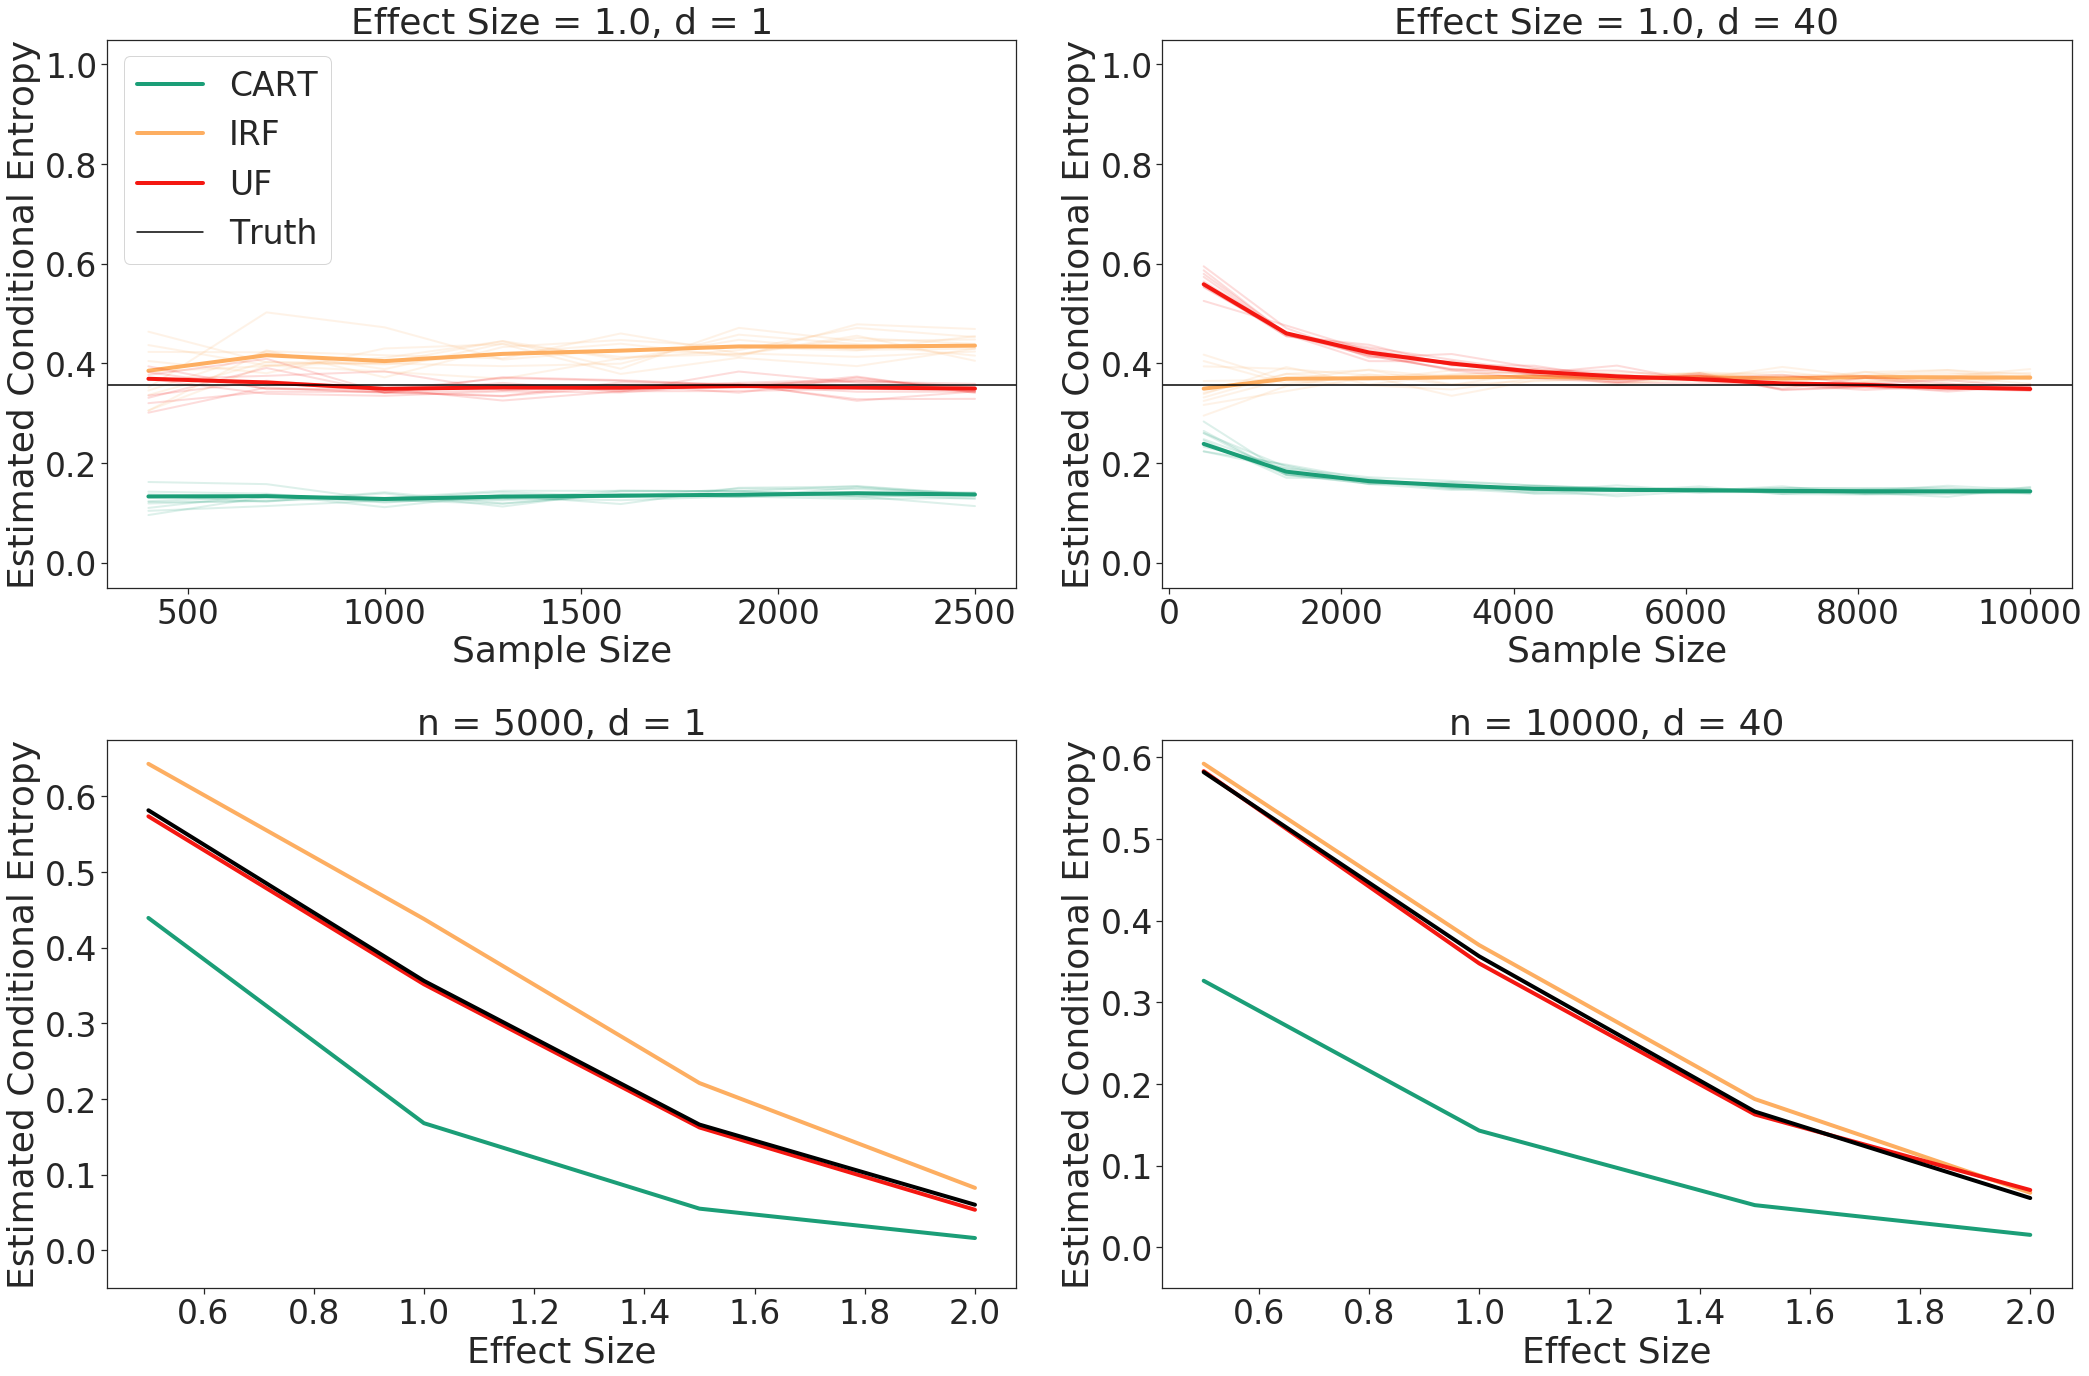

In [21]:
plot_fig2(num_plotted_trials, d1, d2, n1, n2, effect_size)